# Принятие решений в бизнесе, на примере интернет-магазина 

## Описание проекта

Мы работаем в крупном интернет-магазине. И на данный момент с помощью отдела маркетинга мы подготовили список гипотез для увеличения выручки.

Мы приоритизируем гипотезы, запустим A/B тест и проанализируем результаты.

### Описание данных

#### Данные для первой части
Файл /datasets/hypothesis.csv. 
Файл hypothesis содержит:
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

#### Данные для второй части
Файл /datasets/orders.csv. 
Файл orders содержит:
    
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Файл /datasets/visitors.csv. 
Файл visitors содержит:
    
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

### Подготовка данных к анализу

#### Импорт библиотек

In [3]:
import pandas as pd
import numpy as np
import requests
import math as mth
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
from pymystem3 import Mystem
from collections import Counter
from scipy import stats as st
import datetime as dt
import scipy.stats as stats

import plotly.express as px
from plotly import graph_objects as go

#### Чтение и подготовка данных

In [4]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv', sep = ',')
visitors = pd.read_csv('/datasets/visitors.csv',sep = ',')

In [5]:
display(hypothesis)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [6]:
display(orders)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [7]:
display(visitors)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


In [8]:
#приведем к нижнему регистру названия столбцов у hypothesis:
hypothesis.columns = map(str.lower, hypothesis.columns)

In [9]:
#проверка
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [10]:
#проверка на пропуски:
hypothesis.isna().sum()

hypothesis    0
reach         0
impact        0
confidence    0
efforts       0
dtype: int64

In [11]:
#преобразование данных orders столбец даты в формат даты:
orders['date'] = pd.to_datetime(orders['date']).dt.date  
display(orders)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [12]:
#преобразование данных visitors столбец даты в формат даты:
visitors['date'] = pd.to_datetime(visitors['date']).dt.date  
display(visitors)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


#### Вывод:
В данной подготовке: 
- мы загрузили библиотеки;
- открыли для чтения файлы: hypothesis, orders, visitors;
- привели к нижнему регистру названия столбцов у hypothesis;
- проверили на пропуски hypothesis;
- преобразовали данные orders,visitors столбцы даты в формат даты.

## Приоритизация гипотез.

### Применение фреймворк ICE для приоритизации гипотез. 

#### ICE (от англ. impact, confidence, effort / ease «влияние, уверенность, усилия / простота») — один из самых популярных способов приоритизации задач:

In [13]:
# Посчитаем ICE для гипотез по формуле: ICE_SCORE = (impact * confidence)/efforts: 
hypothesis['ICE'] = ( hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
display(hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False).round(2))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день...",16.20
0,"Добавить два новых канала привлечения трафика,...",13.33
7,Добавить форму подписки на все основные страни...,11.20
6,Показать на главной странице баннеры с актуаль...,8.00
2,Добавить блоки рекомендаций товаров на сайт ин...,7.00
1,"Запустить собственную службу доставки, что сок...",2.00
5,"Добавить страницу отзывов клиентов о магазине,...",1.33
3,"Изменить структура категорий, что увеличит кон...",1.12
4,"Изменить цвет фона главной страницы, чтобы уве...",1.00


Спасибо

##### Вывод: Самая популярная гипотеза '8' - "запустить акцию, дающую скидку на товар".

### Применим фреймворк RICE для приоритизации гипотез.

#### У этого метода есть модификация RICE (R от англ. reach, «охват»):

In [14]:
# Посчитаем RICE для гипотез по формуле: (reach * impact * confidence) / efforts:
hypothesis['RICE'] = (hypothesis['reach'] *  hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
display(hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False).round(2))

,hypothesis,RICE
7,Добавить форму подписки на все основные страни...,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,56.0
0,"Добавить два новых канала привлечения трафика,...",40.0
6,Показать на главной странице баннеры с актуаль...,40.0
8,"Запустить акцию, дающую скидку на товар в день...",16.2
3,"Изменить структура категорий, что увеличит кон...",9.0
1,"Запустить собственную службу доставки, что сок...",4.0
5,"Добавить страницу отзывов клиентов о магазине,...",4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3.0


##### Вывод: Самая популярная гипотеза '7' - "добавить форму подписки на все основные страницы".

### Рассмотрим, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объяснение, почему так произошло.

In [15]:
#Рассмотрим hypothesis при применении RICE вместо ICE:
display(hypothesis.sort_values(by='RICE', ascending=False))

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.200000,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.333333,40.0
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.200000,16.2
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.125000,9.0
1,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.000000,3.0


#### Вывод:
При обоих методах гипотезы:
- "7" - "добавить форму подписки на все основные страницы", правда для RICE приоритете, а для ICE на третьей позиции. 
- "0" - "добавить два новых канала привлечения трафика", для RICE на третьей позиции, а для ICE на второй.
- Эти гипотезы в целом для привлечения больше пользователей, т.к. форму подписки на основных страницах увидят почти все посетители сайта, а новые каналы трафика вероятно 30% пользователей.
Пять лучших гипотез для обоих методов: 7, 2, 0, 6, 8.

При расчете ICE и RICE: 
- гипотеза "7" - на первом месте для "RICE" 
- для "ICE" - "8" - "Запустить акцию, дающую скидку на товар в день рождения". 
- Так получилось потому, что у "RICE" -  7й параметр reach равен 10, в то время как у остальных гипотез он меньше.
Параметр охвата (Reach), использующийся в методе RICE изменил всю приоритетность, полученную по методу ICE.
Кроме самой гипотезы нужно учитывать и то, сколько пользователей она затронет.


## Анализ A/B-теста.

### Построение графика кумулятивной выручки по группам.

#### Подготовка данных

In [16]:
#просмотр данных orders:
display(orders.head(10))

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


In [17]:
#просмотр данных visitors:
display(visitors.head(10))

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


In [18]:
#Проверим, есть ли пользователи, которые попали в обе группы:
duplicates_users = np.intersect1d(orders.query('group == "A"')['visitorId'].unique(), orders.query('group == "B"')['visitorId'].unique())
display(duplicates_users)

array([   8300375,  199603092,  232979603,  237748145,  276558944,
        351125977,  393266494,  457167155,  471551937,  477780734,
        818047933,  963407295, 1230306981, 1294878855, 1316129916,
       1333886533, 1404934699, 1602967004, 1614305549, 1648269707,
       1668030113, 1738359350, 1801183820, 1959144690, 2038680547,
       2044997962, 2378935119, 2458001652, 2579882178, 2587333274,
       2600415354, 2654030115, 2686716486, 2712142231, 2716752286,
       2780786433, 2927087541, 2949041841, 2954449915, 3062433592,
       3202540741, 3234906277, 3656415546, 3717692402, 3766097110,
       3803269165, 3891541246, 3941795274, 3951559397, 3957174400,
       3963646447, 3972127743, 3984495233, 4069496402, 4120364173,
       4186807279, 4256040402, 4266935830])

In [19]:
display('Общее количество пользователей до удаления "двойных" пользователей:', orders['visitorId'].nunique())
display('количество пользователей в группе А:', orders.query('group == "A"')['visitorId'].nunique())
display('количество пользователей в группе В:', orders.query('group == "B"')['visitorId'].nunique())

'Общее количество пользователей до удаления "двойных" пользователей:'

1031

'количество пользователей в группе А:'

503

'количество пользователей в группе В:'

586

In [20]:
display('Итого "двойных пользователей":',len(duplicates_users))

'Итого "двойных пользователей":'

58

##### Аргументация: 
Таких пользователей - 58, это около 10% в каждой группе. Их участие сразу в обоих группах может субъективно исказить результаты, а также повлиять на расчет выбросов. Но поскольку нам известны только id пользователей, совершивших хоть один платеж, а "неплатящие" неизвестны, то удаление таких пользователей может также исказить результаты в сторону "неплатящих". Оставим их в данных.

In [21]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates() 

In [22]:
#Соберём агрегированные кумулятивные по дням данные о заказах в несколько действий. 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])

cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

display(cumulativeData.head(5)) 

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


#### Построим графики кумулятивной выручки по дням и группам A/B-тестирования: 

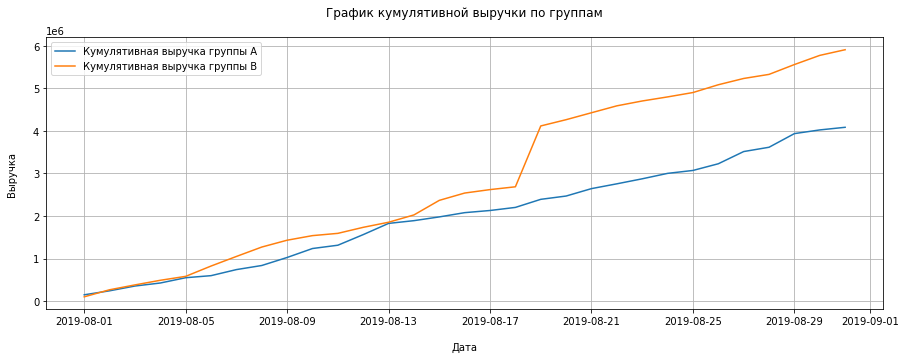

In [23]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.figure(figsize=(15,5))
#Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='Кумулятивная выручка группы A')
#Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='Кумулятивная выручка группы B')
plt.title('График кумулятивной выручки по группам\n  ')
plt.xlabel('\nДата')
plt.ylabel('Выручка\n')
plt.grid()
plt.legend();


Спасибо большое!

#### Вывод:
Выручка увеличивается в течение всего теста у обоих групп. Хороший знак.
Однако график выручки группы B значительно быстрее растет, особенно есть скачок 19-08-2019. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. 

### Построим график кумулятивного среднего чека по группам. 

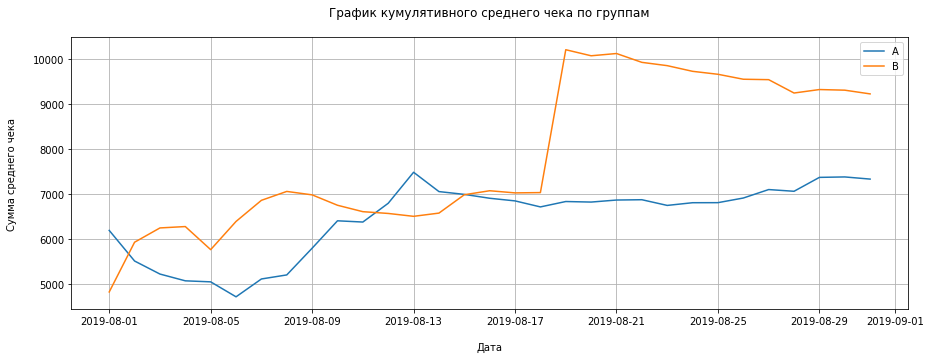

In [24]:
#Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов:
plt.figure(figsize=(15,5))
plt.grid()

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')

plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.title('График кумулятивного среднего чека по группам\n  ')
plt.xlabel('\nДата')
plt.ylabel('Сумма среднего чека\n')
plt.legend()

#### Вывод: 
В среднем чеке есть положительный скачок группы B - дата "19-08-2019", а затем равномерное снижение у группы B, но в целом тест B выдает значительно лучшие показания среднего чека по группам.
У теста группы А существуют скачок снижения - "06-08-2019" и скачок увеличения "13-08-2019", а затем стабильно все без скачков.
Но в целом группа B имеет лучше показатели, чем группа A.

### Построим график относительного изменения кумулятивного среднего чека группы B к группе A. 

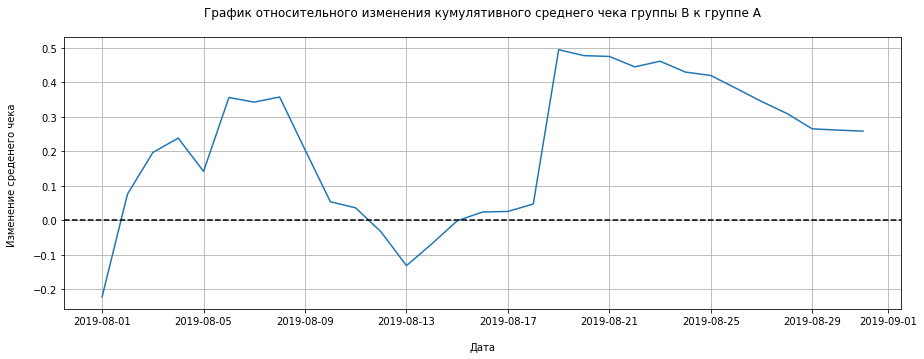

In [25]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.figure(figsize=(15,5))
plt.grid()
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A\n  ')
plt.xlabel('\nДата')
plt.ylabel('Изменение среденего чека \n')
# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 

#### Вывод:
В нескольких точках (а точнее в датах: 05-08-2019, 07-08-2019, 13-08-2019,19-08-2019). График относительного изменения между сегментами резко «скачет». Где-то уж точно спрятались крупные заказы и выбросы! 

### Построим график кумулятивного среднего количества заказов на посетителя по группам.

(18109.0, 18140.0, 0.0, 0.05)

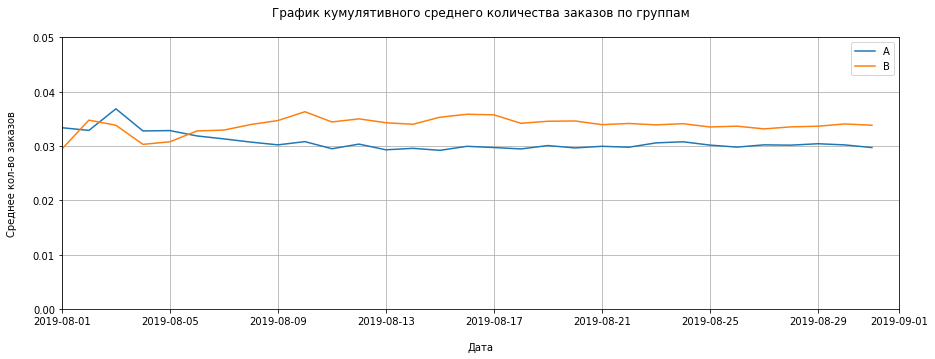

In [26]:
#считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(15,5))
plt.grid()

plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

plt.title('График кумулятивного среднего количества заказов по группам\n  ')
plt.xlabel('\nДата')
plt.ylabel('Среднее кол-во заказов\n')
plt.legend()
# задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), 0, 0.05])

#### Вывод:
Вначале периода группа А была немного выше группы B, но затем сегменты выровнялись и группа B стала значительно приоритетнее группы А.

### Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. 

Text(0, 0.5, 'Относительне изменение количества заказов\n')

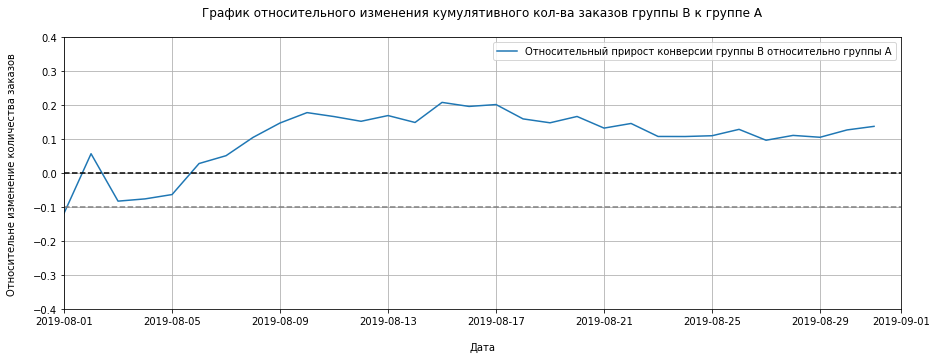

In [27]:
#Построим график относительного различия кумулятивных конверсий:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(15,5))
plt.grid()
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-09-01', -0.4, 0.4])
plt.title('График относительного изменения кумулятивного кол-ва заказов группы B к группе A\n  ')
plt.xlabel('\nДата')
plt.ylabel('Относительне изменение количества заказов\n')

#### Вывод:
В целом количество заказов группы B имеет значительное превосходство по отношению группы А. Относительный прирост группы B относительно группы A +10 до +20 выше относительно группы A. 

### Построим точечный график количества заказов по пользователям.

In [28]:
#Подсчитаем количество заказов по пользователям и посмотрим на результат:
ordersByUsers = orders.groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})

ordersByUsers.columns = ['user_id','orders']

ordersByUsers.sort_values(by='orders',ascending=False).head(10)



,user_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


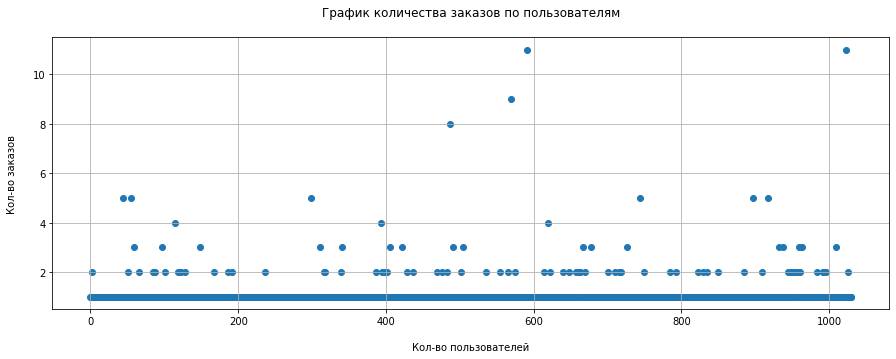

In [29]:
#Построим точечную диаграмму числа заказов на одного пользователя:
plt.figure(figsize=(15,5))
plt.grid()
plt.title('График количества заказов по пользователям\n  ')
plt.xlabel('\nКол-во пользователей')
plt.ylabel('Кол-во заказов\n')

x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders']) 

#### Вывод: 
Судя по графику заказов по пользователям, больше всех пользователи заказывали по 1му заказу, но достаточно большой процент от 2 до 5 заказов.
Даже по подсчету на одного пользователя , когда вывели первых десять пользователей, прояснилось, что большое кол-во пользователей совершает 5 заказов.

### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.

In [30]:
#Посчитаем выборочные перцентили количества заказов на одного пользователя (95й и 99й):
print(np.percentile(ordersByUsers['orders'], [95, 99])) 

[2. 4.]


#### Вывод: 
На перцентиле 95м - это до 5% совершают два заказа, и на 99м перцентиле - 1% совершают 4 заказа. Граница аномальных пользователей: все, что более 4х заказов.

### Построим точечный график стоимостей заказов.

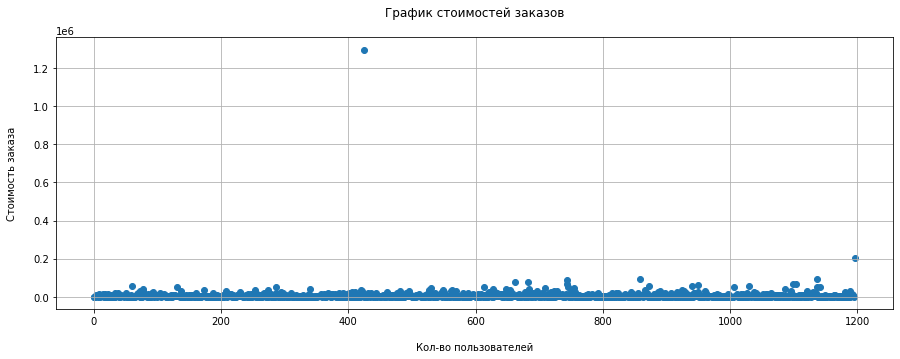

In [31]:
#Построим точечную диаграмму стоимости заказов на одного пользователя:
plt.figure(figsize=(15,5))
plt.grid()

plt.title('График стоимостей заказов\n ')
plt.xlabel('\nКол-во пользователей')
plt.ylabel('Стоимость заказа\n')

x_values = pd.Series(range(0,len(orders['revenue'])))

plt.scatter(x_values, orders['revenue']) 

#### Вывод:
По графику видно всего два выброса, в размере 120k и 20k заказов.

In [32]:
#Посмотрим точные суммы аномальных заказов.
orders['revenue'].sort_values().tail()

744       86620
1136      92550
858       93940
1196     202740
425     1294500
Name: revenue, dtype: int64

Два аномальных заказа: 1294500 и 202740.

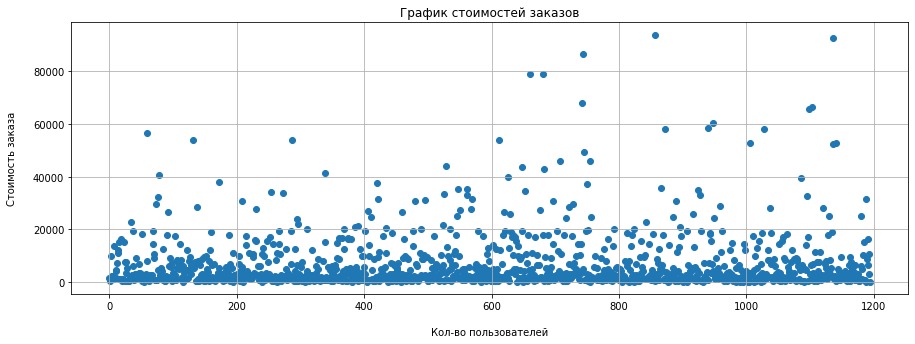

In [33]:
#Построим график на срезе без аномальных заказов:
normal_orders = orders.query('revenue <= 200000')['revenue']
xn_values = pd.Series(range(0,len(normal_orders)))
plt.figure(figsize=(15,5))
plt.grid()
plt.title('График стоимостей заказов')
plt.xlabel('\nКол-во пользователей')
plt.ylabel('Стоимость заказа\n')
plt.scatter(xn_values, normal_orders)

#### Вывод:
Теперь стало понятно, что большая часть заказов сформирована в диапазоне от 1 до 20 000.

### Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.

In [44]:
#Определим 95й и 99й перцентили среднего чека в выборке:
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


#### Вывод:
на 95м перцентиле - это до 95% - заказы на сумму до 28000, остальные 4% - заказы от 28000 до 58000, а 1% заказов - 99 перцентиль - заказы на сумму 58233.2 тыс. Граница аномальных заказов, все , что свыше 58233.2.

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.

#### Начнём с подготовки данных. Изучим код и устройство таблиц visitors и orders.Cоберем общую таблицу.


##### Сформулируем гипотезы:
H0 - Нулевая: различий в среднем количестве заказов между группами нет;
H1 - Альтернативная: различия в среднем между группами есть.

Мы выбрали уровень значимости, равный 0.05.
alpha = 0.05

Для тестирования воспользуемся критерием Манна-Уитни.

In [45]:
#Посчитаем статистическую значимость различий в среднем числе заказов на пользователя
#и среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей.
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']
display(visitorsBCummulative.head(5))


,date,visitorsCummulativeB
31,2019-08-01,713
32,2019-08-02,1294
33,2019-08-03,1803
34,2019-08-04,2573
35,2019-08-05,3280


In [46]:
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]
display(ordersBCummulative.head(5))

,date,ordersCummulativeB,revenueCummulativeB
0,2019-08-01,21,101217
1,2019-08-02,45,266748
2,2019-08-03,61,380996
3,2019-08-04,78,489567
4,2019-08-05,101,581995


In [47]:
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5)) 

         date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0  2019-08-01              24           148579              21   
1  2019-08-02              20            93822              24   
2  2019-08-03              24           112473              16   
3  2019-08-04              16            70825              17   
4  2019-08-05              25           124218              23   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0           101217                  24               148579   
1           165531                  44               242401   
2           114248                  68               354874   
3           108571                  84               425699   
4            92428                 109               549917   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  21               101217               719   
1                  45               266748               619   
2                  61           

Теперь мы можем посчитать статистическую значимость различия в конверсии между группами.
Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders']. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [48]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders'] 

  Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.
  Переменная sampleA должна состоять из двух частей:
- Список с количеством заказов для каждого из пользователей: ordersByUsersA['orders'].
- Нули для пользователей, которые ничего не заказывали. 

Их количество равно разнице между суммой посетителей и количеством записей о заказах: data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders']). 
Создадим объект pd.Series нужной длины:

In [49]:
pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')

0        0
1        0
2        0
3        0
4        0
        ..
18228    0
18229    0
18230    0
18231    0
18232    0
Name: orders, Length: 18233, dtype: int64

In [50]:
[ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')] 

[0      1
 1      1
 2      1
 3      1
 4      1
       ..
 498    1
 499    7
 500    1
 501    1
 502    1
 Name: orders, Length: 503, dtype: int64,
 0        0
 1        0
 2        0
 3        0
 4        0
         ..
 18228    0
 18229    0
 18230    0
 18231    0
 18232    0
 Name: orders, Length: 18233, dtype: int64]

In [51]:
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print("{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.01679
0.138


#### Вывод: 
Первое число — p-value = 0.017 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем. А относительный прирост группы В к А равен 13.8% — второе число в выводе.

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. 

#### Сформулируем гипотезы в среднем чеке заказа между группами по «сырым» данным:
Ho - Нулевая: различий в среднем количестве заказов между группами нет

H1 - Альтернативная: различия в среднем чеке заказа между группами есть.

alpha = 0.05

Метод, который будем применять для A/B-тестирования, называется st.mannwhitneyu() (от англ. «U-критерий Манна-Уитни»).
Ключевая идея — проранжировать две выборки по порядку от меньшего к большему и сравнить ранги одних и тех же значений, попавших в обе выборки.

In [52]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

0.729
0.259


#### Вывод:
P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Впрочем, средний чек группы B выше среднего чека группы A на 26%.

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «отфильтрованным» данным.

#### Описание:

Примем за аномальных пользователей тех, кто совершил от 4 заказов или совершил заказ дороже 58 233 рублей.

Сделаем срезы пользователей с числом заказов больше 4 — usersWithManyOrders
и пользователей, совершивших заказы дороже 58 233 — usersWithExpensiveOrders.
Объединим их в таблице abnormalUsers. 

In [53]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 4]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 4]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 58233]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
display(abnormalUsers.head(5))
display("Всего аномальных пользователей =" ,len(abnormalUsers)) 

1099     148427295
949      887908475
744      888512513
1103    1164614297
1136    1307669133
dtype: int64

'Всего аномальных пользователей ='

15

Всего 15 аномальных пользователей. 

Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по "отфильтрованным" данным.

#### Сформулируем гипотезы по отфильтрованным данным:
Ho - Нулевая: различий в среднем количестве заказов между группами нет.

H1 - Альтернативная: различия в среднем между группами есть.

alpha = 0.05

Метод, который будем применять для A/B-тестирования, называется st.mannwhitneyu() (от англ. «U-критерий Манна-Уитни»).
Ключевая идея — проранжировать две выборки по порядку от меньшего к большему и сравнить ранги одних и тех же значений, попавших в обе выборки.

Напомним, что:

в sampleA сохранили выборку, где каждый элемент — число заказов определённого пользователя, в том числе ноль. Значит, число элементов sampleA — это количество пользователей, сумма всех элементов — количество заказов. Чтобы получить среднее число заказов на пользователя, поделим сумму заказов на число пользователей — находим среднее в выборке sampleA методом mean().

Аналогично находим среднее группы B: SampleB.mean()

In [54]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

print('{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))

print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

0.014
0.153


#### Вывод:
Первое число — p-value = 0.014 меньше 0.05. (на 0.03 меньше показателя по сырым данным) 
Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем.
А относительный прирост группы В к А равен 15.3% — второе число в выводе. Это значит , что группа B реально лидирует в заказах.

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

#### Сформулируем гипотезы «очищенным» данным:
Ho - Нулевая: различий значимость различий в среднем чеке заказа между группами по «очищенным» данным.

H1 - Альтернативная: различия в среднем чеке заказа по "очищенным" данным между группами есть.

alpha = 0.05

Метод, который будем применять для A/B-тестирования, называется st.mannwhitneyu() (от англ. «U-критерий Манна-Уитни»).
Ключевая идея — проранжировать две выборки по порядку от меньшего к большему и сравнить ранги одних и тех же значений, попавших в обе выборки.

In [55]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

0.851
-0.006


#### Вывод:
P-value = 0.851, значительно больше 0.05. Поэтому можем считать, что в среднем чеке нет различий (как и с "сырыми" данными). А вот средний чек группы B оказался незначительно (на 0.6%) ниже среднего чека группы A, в то время как по "сырым" данным, он был больше почти на ~26%. Заказы с большими суммами значительно повлияли на группу B.

## Какие выводы по тесту можем сделать:

### Имеющиеся факты:

- Есть статистически значимое различие по среднему количеству заказов между группами как по сырым данным, так и после фильтрации аномалий;

- Нет статистически значимого различия по среднему количеству заказов между группами ни по «сырым», ни по данным после фильтрации аномалий;

- График различия среднего количества заказов между группами сообщает, что результаты группы A хуже группы B и нет значительной тенденции к улучшению;


### Вывод: 
Исходя из обнаруженных фактов, тест следует остановить и признать его успешным в победе группы "B". Продолжать смысла нет, потому как вероятность, что при имеющихся данных сегмент A на самом деле лучше сегмента B — практически нулевая. В дальнейшем, можно передать данные в отдел маркетинга над доработкой показателей количества заказов.